✅ Diversified portfolio plan saved → /Users/gun/Desktop/미래에셋 AI 공모전/notebooks/results/ensemble_diversified/final_portfolio_plan_diversified.csv
     stock_code  cluster    y_pred      p_up  ensemble_score  weight  \
950      200780        0  0.072767  0.963595        0.217074  0.0477   
3184     296640        0  0.059173  0.984388        0.209701  0.0461   
3498     001750        0  0.034046  0.981108        0.179385  0.0394   
3368     281820        0  0.026867  0.953412        0.160021  0.0352   
2358     019990        0  0.031746  0.926692        0.154964  0.0340   
2721     294570        1  0.121526  0.933311        0.461241  0.1013   
2740     035080        1  0.113200  0.936624        0.452955  0.0995   
3400     001720        1  0.049469  0.986257        0.399248  0.0877   
2636     460940        1  0.059085  0.925081        0.385877  0.0848   
469      198440        1  0.068870  0.782784        0.340252  0.0747   
2634     219550        2  0.054853  0.932719        0.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmu

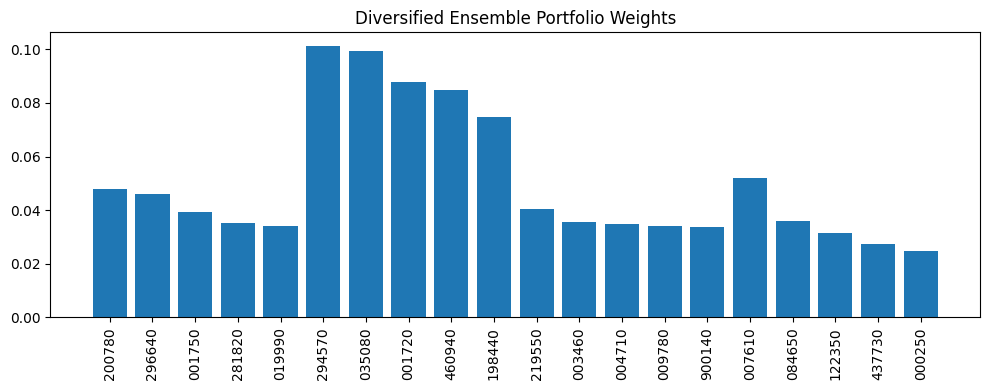

In [2]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────
# 1) 경로 설정 (본인 환경에 맞게 수정)
BASE_DIR        = "/Users/gun/Desktop/미래에셋 AI 공모전/data"
CLF_MODEL_FP    = os.path.join(BASE_DIR, "models", "lgbm_classifier.pkl")
REG_PRED_FP     = os.path.join(BASE_DIR, "results", "regression", "regression_predictions_for_ensemble.csv")
CLF_CSV_FP      = os.path.join(BASE_DIR, "module_datasets", "classification_with_text.csv")

# 출력 디렉토리 (현재 작업 디렉토리 기준)
WORK_DIR        = os.getcwd()
OUTPUT_DIR      = os.path.join(WORK_DIR, "results", "ensemble_diversified")
os.makedirs(OUTPUT_DIR, exist_ok=True)
PLAN_FP         = os.path.join(OUTPUT_DIR, "final_portfolio_plan_diversified.csv")

# ───────────────────────────────────────────────────────────────
# 2) 분류 확률(p_up) 로드
clf = joblib.load(CLF_MODEL_FP)
df_clf = pd.read_csv(CLF_CSV_FP, parse_dates=["rcept_dt"], dtype={"stock_code":str})
X_clf = df_clf.drop(columns=["up_1d","corp_name","stock_code","rcept_dt"], errors="ignore")
df_clf["p_up"] = clf.predict_proba(X_clf)[:, 1]

# ───────────────────────────────────────────────────────────────
# 3) 회귀 예측 로드
df_reg = pd.read_csv(REG_PRED_FP, parse_dates=["rcept_dt"], dtype={"stock_code":str})

# ───────────────────────────────────────────────────────────────
# 4) 데이터 병합
df = pd.merge(df_reg, df_clf[["stock_code","rcept_dt","p_up"]],
              on=["stock_code","rcept_dt"], how="left")

# ───────────────────────────────────────────────────────────────
# 5) 클러스터 재생성 (y_pred, residual)
scaler = StandardScaler()
scaled = scaler.fit_transform(df[["y_pred","residual"]])
df["cluster"] = KMeans(n_clusters=4, random_state=42, n_init=10).fit_predict(scaled)

# ───────────────────────────────────────────────────────────────
# 6) 앙상블 스코어 계산 (가중치 재조정)
alpha, beta, gamma = 0.4, 0.4, 0.2

df["y_pred_scl"]    = (df["y_pred"] - df["y_pred"].min()) / (df["y_pred"].max() - df["y_pred"].min())
df["p_up_adj"]      = df["p_up"] - 0.5
df["cluster_score"] = df["cluster"].map({0:-1, 1:0, 2:-1, 3:1})

df["ensemble_score"] = (
    alpha * df["y_pred_scl"] +
    beta  * df["p_up_adj"] +
    gamma * df["cluster_score"]
)

# ───────────────────────────────────────────────────────────────
# 7) 중복 제거 (종목별 최신 공시만)
df = df.sort_values("rcept_dt").drop_duplicates(subset="stock_code", keep="last")

# ───────────────────────────────────────────────────────────────
# 8) 클러스터 다양성 보장: 각 클러스터당 5개씩, 총 N=20
N = 20
clusters = sorted(df["cluster"].unique())
k_each = N // len(clusters)  # 20/4 = 5

selected = []
for c in clusters:
    top_c = df[df["cluster"]==c].nlargest(k_each, "ensemble_score")
    selected.append(top_c)
selected_df = pd.concat(selected)

# 남는 슬롯 채우기
remain = N - len(selected_df)
if remain > 0:
    rest = df.drop(selected_df.index)
    selected_df = pd.concat([selected_df, rest.nlargest(remain, "ensemble_score")])

plan = selected_df.copy()

# ───────────────────────────────────────────────────────────────
# 9) 포트폴리오 플랜 생성 & 리스크 지침 고도화
plan["weight"] = (plan["ensemble_score"] / plan["ensemble_score"].sum()).round(4)
plan["stop_loss"] = np.where(plan["p_up"] > 0.95, "-2%",
                      np.where(plan["p_up"] > 0.90, "-3%", "-5%"))
plan["take_profit"] = np.where(plan["p_up"] > 0.95, "+8%",
                        np.where(plan["p_up"] > 0.90, "+7%", "+5%"))
plan["rebalance_freq"] = np.where(plan["p_up"] > 0.95, "Monthly",
                           np.where(plan["p_up"] > 0.90, "Bi-Monthly", "Quarterly"))

final_cols = [
    "stock_code","cluster","y_pred","p_up","ensemble_score",
    "weight","stop_loss","take_profit","rebalance_freq"
]
final_plan = plan[final_cols]
final_plan.to_csv(PLAN_FP, index=False, encoding="utf-8-sig")

# ───────────────────────────────────────────────────────────────
# 10) 결과 출력 & 시각화
print(f"✅ Diversified portfolio plan saved → {PLAN_FP}")
print(final_plan)

plt.figure(figsize=(10,4))
plt.bar(final_plan["stock_code"], final_plan["weight"])
plt.xticks(rotation=90)
plt.title("Diversified Ensemble Portfolio Weights")
plt.tight_layout()
plt.show()